In [1]:
import numpy as np
import torch
from torch import nn
import math
from pprint import pprint
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

Load the data

In [2]:
train = pd.read_csv("./train.csv")
test_comments = pd.read_csv("./test.csv")
test_labels = pd.read_csv("./test_labels.csv")

Combine the test_comments and test_labels

In [3]:
test = pd.merge(test_comments, test_labels, on="id")

Remove -1 values indicating that an output isn't used for scoring and add a column that is 1 when all other labels are 0.

In [4]:
test.toxic = test_labels.toxic.clip(0)
test.severe_toxic = test_labels.severe_toxic.clip(0)
test.obscene = test_labels.obscene.clip(0)
test.threat = test_labels.threat.clip(0)
test.insult = test_labels.insult.clip(0)
test.identity_hate = test_labels.identity_hate.clip(0)

def make_nontoxic(df):
    df["nontoxic"] = (1-df.toxic) * (1-df.severe_toxic) * (1 - df.obscene) * (1 - df.threat) * (1 - df.insult)

make_nontoxic(train)
make_nontoxic(test)
test

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,nontoxic
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,0,0,0,0,0,0,1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0,0,0,0,0,0,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0,0,0,0,0,0,1
3,00017563c3f7919a,":If you have a look back at the source, the in...",0,0,0,0,0,0,1
4,00017695ad8997eb,I don't anonymously edit articles at all.,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",0,0,0,0,0,0,1
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,0,0,0,0,0,0,1
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",0,0,0,0,0,0,1
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",0,0,0,0,0,0,1


Summarize the training set

In [16]:
def summarize_probs(df):
    n_toxic = df.toxic.sum()
    n_severe_toxic = df.severe_toxic.sum()
    n_obscene = df.obscene.sum()
    n_threat = df.threat.sum()
    n_insult = df.insult.sum()
    n_identity_hate = df.identity_hate.sum()
    n = len(df)

    n_nontoxic = df.nontoxic.sum()

    print("{:6d} / {} = {:.04f}% are non-toxic".format(n_nontoxic, n, n_nontoxic*100 / n))

    print("{:6d} / {} = {:.04f}% are toxic".format(n_toxic, n, n_toxic*100 / n))
    print("{:6d} / {} = {:.04f}% are severely toxic".format(n_severe_toxic, n, n_severe_toxic*100 / n))
    print("{:6d} / {} = {:.04f}% are obscene".format(n_obscene, n, n_obscene*100 / n))
    print("{:6d} / {} = {:.04f}% are threats".format(n_threat, n, n_threat*100 / n))
    print("{:6d} / {} = {:.04f}% are insults".format(n_insult, n, n_insult*100 / n))
    print("{:6d} / {} = {:.04f}% are identity-based hate".format(n_identity_hate, n, n_identity_hate*100 / n))

print("Training set")
summarize_probs(train)
print()
print("Test set")
summarize_probs(test)

Training set
143400 / 159571 = 89.8660% are non-toxic
 15294 / 159571 = 9.5844% are toxic
  1595 / 159571 = 0.9996% are severely toxic
  8449 / 159571 = 5.2948% are obscene
   478 / 159571 = 0.2996% are threats
  7877 / 159571 = 4.9364% are insults
  1405 / 159571 = 0.8805% are identity-based hate

Test set
146935 / 153164 = 95.9331% are non-toxic
  6090 / 153164 = 3.9761% are toxic
   367 / 153164 = 0.2396% are severely toxic
  3691 / 153164 = 2.4098% are obscene
   211 / 153164 = 0.1378% are threats
  3427 / 153164 = 2.2375% are insults
   712 / 153164 = 0.4649% are identity-based hate


In [17]:
def joint(a, b):
    return (train[a]*train[b]).sum() / len(train)

def conditional(a, b):
    p_b = train[b].sum() / len(train)
    return joint(a, b) / p_b

conditional("severe_toxic", "toxic")

0.10428926376356741

In [27]:
columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
for i in range(len(columns)):
    for j in range(i, len(columns)):
        print("P({}, {}) = {:04f}%".format(columns[i], columns[j], 100*joint(columns[i], columns[j])))

NameError: name 'joint' is not defined

In [31]:
keys = np.zeros((2**6, 6))

counts = np.zeros(2**6)
for row in train[columns].to_numpy():
    index = 0
    for i in range(6):
        index += row[i]*2**(5-i)
    keys[index] = row
    counts[index] += 1
keys = keys[counts != 0]
counts = counts[counts != 0]

for i in range(counts.shape[0]):
    print("{}: {:.04f}%".format(keys[i], 100 * counts[i] / len(train)))

[0. 0. 0. 0. 0. 0.]: 89.8321%
[0. 0. 0. 0. 0. 1.]: 0.0338%
[0. 0. 0. 0. 1. 0.]: 0.1886%
[0. 0. 0. 0. 1. 1.]: 0.0175%
[0. 0. 0. 1. 0. 0.]: 0.0138%
[0. 0. 0. 1. 1. 0.]: 0.0019%
[0. 0. 1. 0. 0. 0.]: 0.1987%
[0. 0. 1. 0. 0. 1.]: 0.0019%
[0. 0. 1. 0. 1. 0.]: 0.1134%
[0. 0. 1. 0. 1. 1.]: 0.0113%
[0. 0. 1. 1. 0. 0.]: 0.0013%
[0. 0. 1. 1. 1. 0.]: 0.0013%
[1. 0. 0. 0. 0. 0.]: 3.5508%
[1. 0. 0. 0. 0. 1.]: 0.0852%
[1. 0. 0. 0. 1. 0.]: 0.7614%
[1. 0. 0. 0. 1. 1.]: 0.0840%
[1. 0. 0. 1. 0. 0.]: 0.0708%
[1. 0. 0. 1. 0. 1.]: 0.0044%
[1. 0. 0. 1. 1. 0.]: 0.0100%
[1. 0. 0. 1. 1. 1.]: 0.0019%
[1. 0. 1. 0. 0. 0.]: 1.1017%
[1. 0. 1. 0. 0. 1.]: 0.0219%
[1. 0. 1. 0. 1. 0.]: 2.3814%
[1. 0. 1. 0. 1. 1.]: 0.3873%
[1. 0. 1. 1. 0. 0.]: 0.0069%
[1. 0. 1. 1. 1. 0.]: 0.0821%
[1. 0. 1. 1. 1. 1.]: 0.0351%
[1. 1. 0. 0. 0. 0.]: 0.0257%
[1. 1. 0. 0. 0. 1.]: 0.0019%
[1. 1. 0. 0. 1. 0.]: 0.0088%
[1. 1. 0. 0. 1. 1.]: 0.0044%
[1. 1. 0. 1. 0. 0.]: 0.0069%
[1. 1. 0. 1. 0. 1.]: 0.0006%
[1. 1. 0. 1. 1. 0.]: 0.0006%
[1. 1. 1. 0. 

Describe the comment text data

In [32]:
train.comment_text.str.len().describe()

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_text, dtype: float64

In [33]:
train.comment_text.str.len().describe()

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_text, dtype: float64

Text(0.5, 1.0, 'Overall Length Distribution')

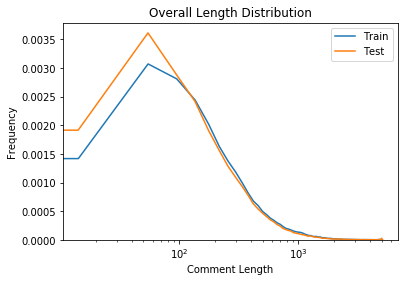

In [34]:
sns.distplot(train.comment_text.str.len(), hist=False, bins=100, label="Train")
sns.distplot(test.comment_text.str.len(), hist=False, bins=100, label="Test")
train.comment_text.str.len().max()
plt.xscale("log")
plt.xlabel("Comment Length")
plt.ylabel("Frequency")
plt.title("Overall Length Distribution")

394.0732213246768


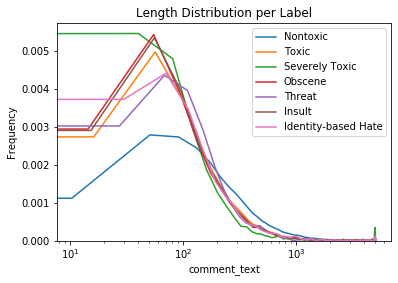

In [35]:
print(train.comment_text.str.len().mean())
plt.xscale("log")
plt.xlabel("Comment Length")
plt.ylabel("Frequency")
plt.title("Length Distribution per Label")
sns.distplot(train.comment_text[train.nontoxic == 1].str.len(), hist=False, bins=100, label="Nontoxic")
sns.distplot(train.comment_text[train.toxic == 1].str.len(), hist=False, bins=100, label="Toxic")
sns.distplot(train.comment_text[train.severe_toxic == 1].str.len(), hist=False, bins=100, label="Severely Toxic")
sns.distplot(train.comment_text[train.obscene == 1].str.len(), hist=False, bins=100, label="Obscene")
sns.distplot(train.comment_text[train.threat == 1].str.len(), hist=False, bins=100, label="Threat")
sns.distplot(train.comment_text[train.insult == 1].str.len(), hist=False, bins=100, label="Insult")
sns.distplot(train.comment_text[train.identity_hate == 1].str.len(), hist=False, bins=100, label="Identity-based Hate")

Text(0, 0.5, 'Frequency')

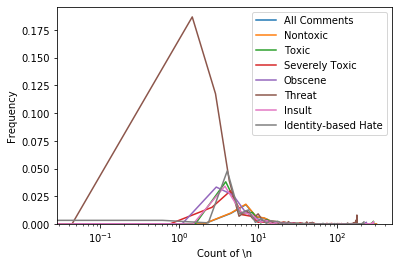

In [36]:
def plot_counts(regex):
    plt.xscale("log")
    sns.distplot(train.comment_text.str.count(regex), hist=False, bins=100, label="All Comments")
    sns.distplot(train.comment_text[train.nontoxic == 1].str.count(regex), hist=False, bins=100, label="Nontoxic")
    sns.distplot(train.comment_text[train.toxic == 1].str.count(regex), hist=False, bins=100, label="Toxic")
    sns.distplot(train.comment_text[train.severe_toxic == 1].str.count(regex), hist=False, bins=100, label="Severely Toxic")
    sns.distplot(train.comment_text[train.obscene == 1].str.count(regex), hist=False, bins=100, label="Obscene")
    sns.distplot(train.comment_text[train.threat == 1].str.count(regex), hist=False, bins=100, label="Threat")
    sns.distplot(train.comment_text[train.insult == 1].str.count(regex), hist=False, bins=100, label="Insult")
    sns.distplot(train.comment_text[train.identity_hate == 1].str.count(regex), hist=False, bins=100, label="Identity-based Hate")
plot_counts("\n")
plt.xlabel("Count of \\n")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

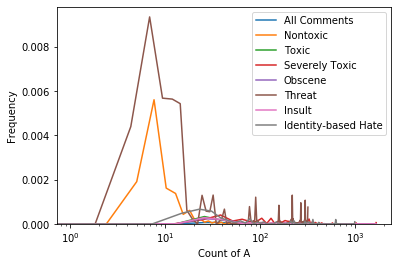

In [41]:
plot_counts("A")
plt.xlabel("Count of A")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

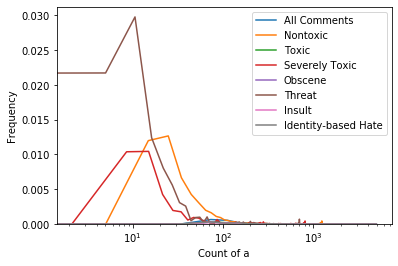

In [42]:
plot_counts("a")
plt.xlabel("Count of a")
plt.ylabel("Frequency")

In [43]:
def get_counts(df):
    charset = [
           'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
           'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
           '1', '2', '3', '4', '5', '6', '7', '8', '9', '0',
           '`', '~', '!', '@', '#', '\\$', '%', '\\^', '&', '\\*', '\\(', '\\)', '-', '=', '_', '\\+', '{', '}', '\\[', ']', '\\\\', '\\|',
           ';', ':', "'", '"', ',', '<', '\\.', '>', '/', '\\?', '\\\\', ' ', '\n', '\t']
    char_counts = [df.comment_text.str.count(char) for char in charset]
    return pd.DataFrame(data=np.array([count.to_numpy() for count in char_counts]).transpose(), columns=charset)
counts_train = get_counts(train)
counts_test = get_counts(test)
counts_train

,a,b,c,d,e,f,g,h,i,j,...,",",<,\.,>,/,\?,\\,,\n,\t
0,16,0,4,10,33,2,1,5,6,1,...,1,0,5,0,0,1,0,41,1,0
1,7,1,4,1,4,0,2,4,3,0,...,2,0,2,0,0,0,0,17,0,0
2,18,1,3,4,17,4,7,7,12,1,...,1,0,3,0,0,0,0,41,0,0
3,39,5,15,14,72,16,7,12,30,0,...,2,0,3,0,0,0,0,111,4,0
4,5,1,2,0,7,0,1,4,1,0,...,2,0,1,0,0,1,0,12,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159566,13,1,12,5,29,5,7,8,17,0,...,3,0,0,0,0,2,0,48,2,0
159567,6,2,0,2,5,2,2,5,3,0,...,0,0,4,0,0,0,0,18,2,0
159568,5,0,3,0,4,1,1,2,6,0,...,1,0,2,0,0,0,0,12,2,0
159569,6,0,1,4,10,1,0,5,6,0,...,0,0,1,0,0,0,0,24,0,0


In [44]:
counts_train.to_csv("train_char_counts.csv")
counts_test.to_csv("test_char_counts.csv")

Preprocess comments into BERT tokens

In [18]:
import torch
from transformers import *

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

encode = lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=10000)

In [7]:
train_encoded = train.comment_text.apply(encode)
test_encoded = test.comment_text.apply(encode)

In [8]:
train_encoded

0         [101, 16409, 1643, 20592, 2116, 2009, 1103, 14...
1         [101, 141, 112, 170, 2246, 2246, 106, 1124, 26...
2         [101, 4403, 1299, 117, 146, 112, 182, 1541, 11...
3         [101, 107, 3046, 146, 1169, 112, 189, 1294, 12...
4         [101, 1192, 117, 6442, 117, 1132, 1139, 6485, ...
                                ...                        
159566    [101, 107, 131, 131, 131, 131, 131, 1262, 1111...
159567    [101, 1192, 1431, 1129, 16155, 1104, 3739, 133...
159568    [101, 156, 18965, 6198, 12189, 1306, 117, 1175...
159569    [101, 1262, 1122, 2736, 1176, 1122, 1108, 2140...
159570    [101, 107, 1262, 119, 119, 119, 146, 1541, 127...
Name: comment_text, Length: 159571, dtype: object

In [25]:
def split(tokenized):
    sections = []
    positions = []
    start = 0
    while start + 512 < len(tokenized):
        sections.append(np.array(tokenized[start:start+512]))
        positions.append(list(range(start, start+512)))
        start += 256
  
    last_section = tokenized[start:]
    sections.append(last_section + [0]*(512-len(last_section)))
    positions.append(list(range(start, start+512)))

  
    return np.array(sections), positions

def separate(encoded, path_format):
    split_comments = []
    positions = []

    for tokenized in encoded:
        split_comment, position_arr = split(tokenized)
        split_comments.append(split_comment)
        positions.append(position_arr)
    
    input_ids = torch.cat([torch.LongTensor(split) for split in split_comments], dim=0)
    flat_positions = torch.cat([torch.LongTensor(pos) for pos in positions], dim=0)
    comment_ids = []
    for i, comment in enumerate(split_comments):
        comment_ids += [i]*comment.shape[0]
    comment_ids = torch.LongTensor(comment_ids)
    
    torch.save(input_ids, path_format.format("_input_ids"))
    torch.save(flat_positions, path_format.format("_positions"))
    torch.save(comment_ids, path_format.format("_ids"))

separate(train_encoded, "train{}.pt")
separate(test_encoded, "test{}.pt")

In [28]:
train_targets = torch.Tensor(train[columns].to_numpy())
test_targets = torch.Tensor(test[columns].to_numpy())

torch.save(train_targets, "train_targets.pt")
torch.save(test_targets, "test_targets.pt")